In [18]:
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta


# Φόρτωση ιστορικών δεδομένων
symbol = "HTZ"
data = yf.download(symbol, start="2024-01-01", end="2025-06-11")

# Έλεγχος αν τα δεδομένα είναι κενά
if data.empty:
    raise ValueError("Δεν φορτώθηκαν δεδομένα. Ελέγξτε το symbol ή τη σύνδεση σας.")

# Έλεγχος αν υπάρχει η στήλη 'Adj Close'
if 'Close' not in data.columns:
    raise KeyError("Η στήλη 'Close' δεν βρέθηκε στα δεδομένα.")

prices = data["Close"]

# Υπολογισμός λογαριθμικών αποδόσεων
log_returns = np.log(prices / prices.shift(1)).dropna()

# Υπολογισμός παραμέτρων GBM
mu = log_returns.mean()  # Μέση λογαριθμική ημερήσια απόδοση
sigma = log_returns.std()  # Ημερήσια μεταβλητότητα

# Μετατροπή σε ετήσια βάση
annual_mu = mu * 252
annual_sigma = sigma * np.sqrt(252)

# Διασφάλιση ότι είναι float
annual_mu = annual_mu.item()  # ή float(annual_mu)
annual_sigma = annual_sigma.item()  # ή float(annual_sigma)

m=annual_mu
sigma=annual_sigma
# Υπολογισμός σημερινής τιμής (τελευταία διαθέσιμη τιμή κλεισίματος)
s0 = data['Close'].iloc[-1].item()

print('')
print(f"Σημερινή Τιμή της μετοχής: {s0:4f}")
print(f"Ετήσια μέση λογαριθμική απόδοση: {annual_mu:.4f}")
print(f"Ετήσια μεταβλητότητα: {annual_sigma:.4f}")

[*********************100%***********************]  1 of 1 completed


Σημερινή Τιμή της μετοχής: 6.160000
Ετήσια μέση λογαριθμική απόδοση: -0.3530
Ετήσια μεταβλητότητα: 0.9570


Εισάγετε την επιθυμητή πιθανότητα επιτυχίας (π.χ. 0.85): 0.9

--- Εισαχθέντες Παράμετροι ---
Αρχική τιμή μετοχής (S0): 6.16
Ετήσια μέση απόδοση (m): -0.3530
Ετήσια μεταβλητότητα (σ): 0.9570
Επιθυμητή πιθανότητα (p): 0.90
Δώστε το χρόνο λήξης Τ σε χρόνια (π.χ. 1); 1
Δώστε το Strike Price (αριθμός); 6
Πόσες προσομοιώσεις ανά σημείο για βελτιστοποίηση (π.χ. 100); 10
Πόσες προσομοιώσεις για ακριβή μέση τιμή Payoff/Vn (π.χ. 10000); 100

Ξεκινάει το binary search για να βρεθεί το ελάχιστο Y που επιτυγχάνει πιθανότητα ≥ 0.90
Έλεγχος Y=6.47 → Μέγιστη πιθανότητα = 1.0000
Έλεγχος Y=3.54 → Μέγιστη πιθανότητα = 1.0000
Έλεγχος Y=2.08 → Μέγιστη πιθανότητα = 1.0000
Έλεγχος Y=1.35 → Μέγιστη πιθανότητα = 0.8000
Έλεγχος Y=1.71 → Μέγιστη πιθανότητα = 0.8000
Έλεγχος Y=1.90 → Μέγιστη πιθανότητα = 1.0000
Έλεγχος Y=1.80 → Μέγιστη πιθανότητα = 0.9000
Έλεγχος Y=1.76 → Μέγιστη πιθανότητα = 0.9000
Έλεγχος Y=1.74 → Μέγιστη πιθανότητα = 0.9000
Έλεγχος Y=1.72 → Μέγιστη πιθανότητα = 0.9000
Έλεγχος Y=1.72 → Μέγιστη π

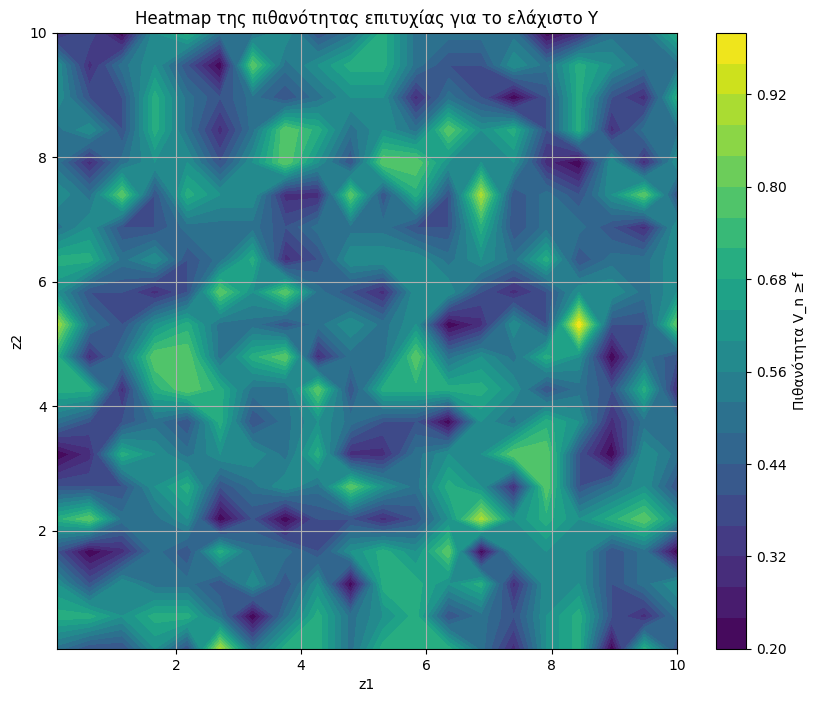


Σχεδίαση ακολουθιών a_k και b_k για μία τυπική προσομοίωση...


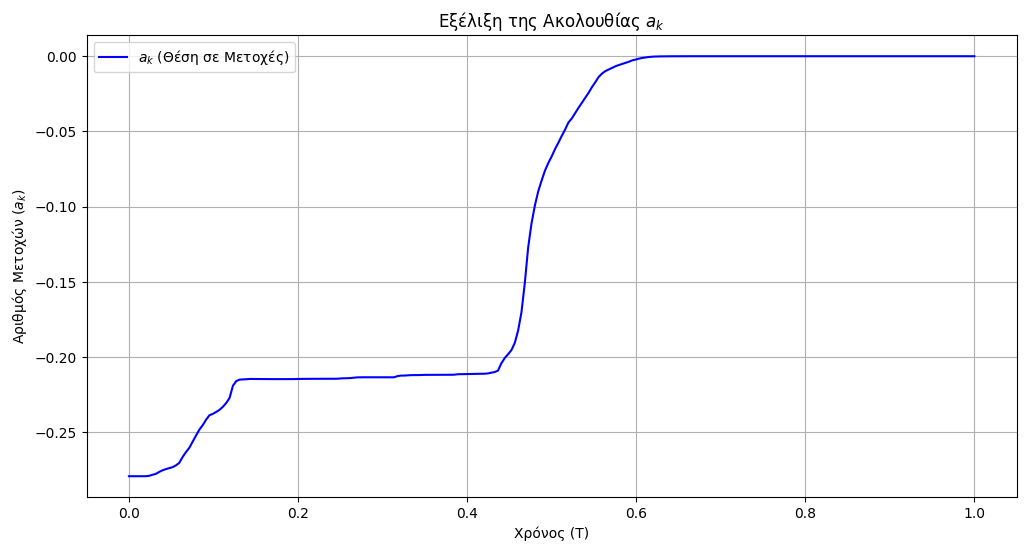

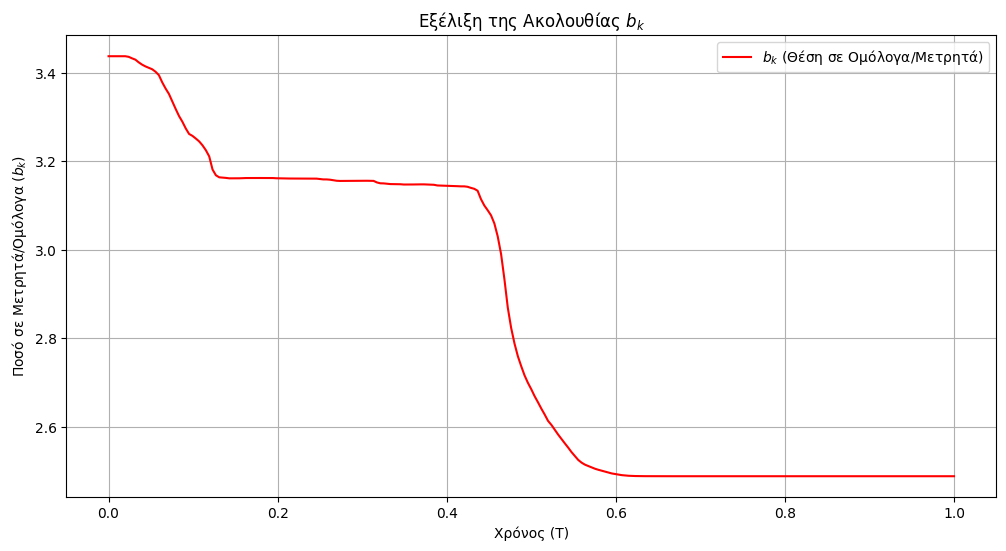

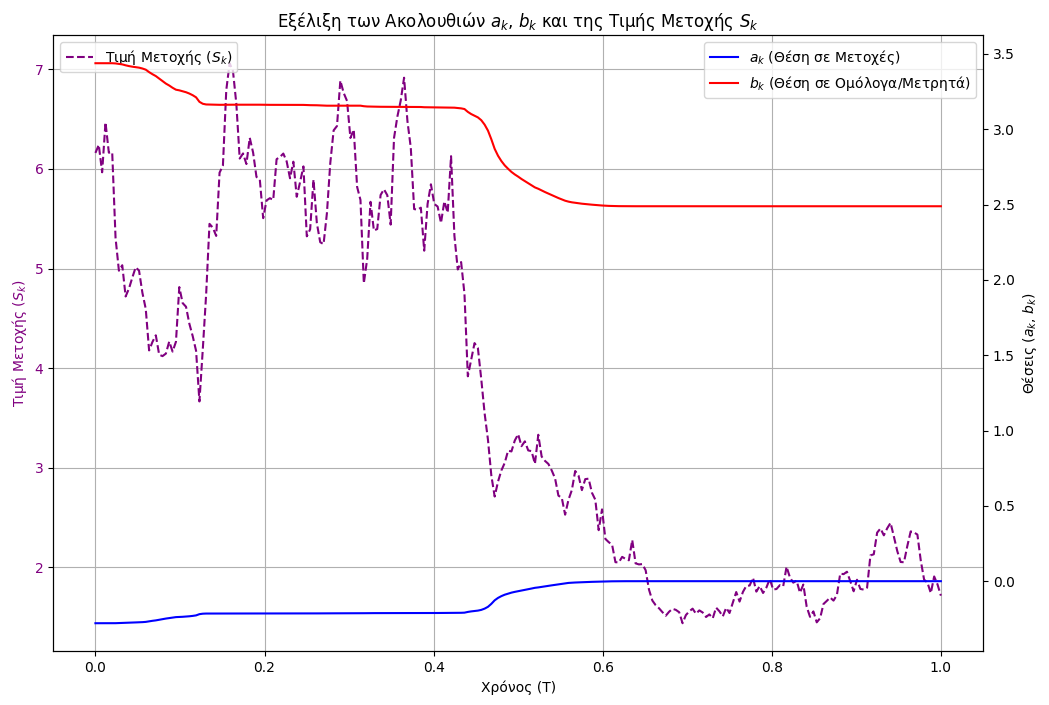

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Βοηθητικές Συναρτήσεις ---
def delta_function(x, z1, z2):
    if not (z1 > 0 and z2 > 0):
        return 0.0
    if x <= 1:
        return 0.0
    numerator = z1 * ((x - 1) ** z2)
    denominator = numerator + 1
    return numerator / denominator

def generate_ak_sequence(initial_a, s_prices, z1, z2):
    if s_prices.size == 0 or len(s_prices) < 1:
        return [initial_a]
    a_sequence = [initial_a]
    s0 = s_prices[0]
    if s0 <= 0:
        return [initial_a] * len(s_prices)
    for k in range(1, len(s_prices)):
        a_k_minus_1 = a_sequence[-1]
        s_tk = s_prices[k]
        if s_tk <= 0:
            a_sequence.extend([a_k_minus_1] * (len(s_prices) - k))
            break
        ratio_stk_s0 = s_tk / s0
        ratio_s0_stk = s0 / s_tk
        delta_stk_s0 = delta_function(ratio_stk_s0, z1, z2)
        delta_s0_stk = delta_function(ratio_s0_stk, z1, z2)
        if initial_a > 0:
            a_k = a_k_minus_1 - a_k_minus_1 * delta_stk_s0 + (initial_a - a_k_minus_1) * delta_s0_stk
        elif initial_a < 0:
            a_k = a_k_minus_1 - a_k_minus_1 * delta_s0_stk + (initial_a - a_k_minus_1) * delta_stk_s0
        else:
            a_k = 0
        a_sequence.append(a_k)
    return a_sequence

def calculate_lookback_call_payoff(s_prices, strike_k):
    if s_prices.size == 0:
        return 0.0
    max_s_t = np.max(s_prices)
    payoff = max(max_s_t - strike_k, 0)
    return float(payoff)

def simulate_gbm_path(s0, m, sigma, T, num_steps):
    dt = T / num_steps
    prices = np.zeros(num_steps + 1)
    prices[0] = s0
    drift_term = (m - 0.5 * sigma ** 2) * dt
    diffusion_term_factor = sigma * np.sqrt(dt)
    random_shocks = np.random.randn(num_steps)
    for i in range(1, num_steps + 1):
        prices[i] = prices[i - 1] * np.exp(drift_term + diffusion_term_factor * random_shocks[i - 1])
        if prices[i] <= 0:
            prices[i] = 1e-6
    return prices

def evaluate_strategy_performance(Y, initial_a, z_params, s0, m, sigma, T, num_steps, strike_k, num_simulations):
    z1, z2 = z_params
    successful_outcomes = 0
    total_payoff = 0.0
    total_Vn = 0.0
    for _ in range(num_simulations):
        simulated_prices = simulate_gbm_path(s0, m, sigma, T, num_steps)
        if np.any(simulated_prices <= 0):
            continue
        a_k_sequence = generate_ak_sequence(initial_a, simulated_prices, z1, z2)
        if len(a_k_sequence) != len(simulated_prices):
            continue
        b_k_sequence = [Y - initial_a * s0]
        for k in range(1, len(simulated_prices)):
            s_k = simulated_prices[k]
            a_k = a_k_sequence[k]
            a_k_minus_1 = a_k_sequence[k - 1]
            b_k = b_k_sequence[-1] - (a_k - a_k_minus_1) * s_k
            b_k_sequence.append(b_k)
        v_n = a_k_sequence[-1] * simulated_prices[-1] + b_k_sequence[-1]
        f_payoff = calculate_lookback_call_payoff(simulated_prices, strike_k)
        total_payoff += f_payoff
        total_Vn += v_n
        if v_n >= f_payoff:
            successful_outcomes += 1
    probability = successful_outcomes / num_simulations if num_simulations > 0 else 0.0
    mean_payoff = total_payoff / num_simulations if num_simulations > 0 else 0.0
    mean_Vn = total_Vn / num_simulations if num_simulations > 0 else 0.0
    return probability, mean_payoff, mean_Vn

def get_user_defined_params():
    p = None
    while p is None:
        try:
            p = float(input("Εισάγετε την επιθυμητή πιθανότητα επιτυχίας (π.χ. 0.85): "))
            if not (0 < p <= 1):
                print("Η πιθανότητα πρέπει να είναι μεταξύ 0 και 1.")
                p = None
        except ValueError:
            print("Μη έγκυρη είσοδος.")
    print(f"\n--- Εισαχθέντες Παράμετροι ---")
    print(f"Αρχική τιμή μετοχής (S0): {s0:.2f}")
    print(f"Ετήσια μέση απόδοση (m): {m:.4f}")
    print(f"Ετήσια μεταβλητότητα (σ): {sigma:.4f}")
    print(f"Επιθυμητή πιθανότητα (p): {p:.2f}")
    return s0, m, sigma, p

def find_optimal_params_for_Y(Y, s0, m, sigma, T, num_steps, strike_k, num_simulations):
    a0_values = np.linspace(-2 * Y / s0, 2 * Y / s0, 5)
    z1_values = np.linspace(0.1, 10, 5)
    z2_values = np.linspace(0.1, 10, 5)
    best_prob = 0.0
    best_a0 = None
    best_z = (None, None)
    best_avg_payoff = 0.0
    best_avg_Vn = 0.0
    for a0 in a0_values:
        for z1 in z1_values:
            for z2 in z2_values:
                prob, avg_payoff, avg_Vn = evaluate_strategy_performance(Y, a0, (z1, z2), s0, m, sigma, T, num_steps, strike_k, num_simulations)
                if prob > best_prob:
                    best_prob = prob
                    best_a0 = a0
                    best_z = (z1, z2)
                    best_avg_payoff = avg_payoff
                    best_avg_Vn = avg_Vn
    return best_a0, best_z, best_prob, best_avg_payoff, best_avg_Vn

def find_min_Y_to_reach_probability(s0, m, sigma, desired_p, T, num_steps, strike_k,
                                     low_Y_ratio=0.1, high_Y_ratio=2.0, tol=0.01, num_simulations=100):
    low = s0 * low_Y_ratio
    high = s0 * high_Y_ratio
    best_Y = None
    best_a0 = None
    best_z = None
    best_prob = 0.0
    best_mean_payoff = 0.0
    best_mean_Vn = 0.0
    print(f"\nΞεκινάει το binary search για να βρεθεί το ελάχιστο Y που επιτυγχάνει πιθανότητα ≥ {desired_p:.2f}")
    iter_count = 0
    max_iters = 100
    while high - low > tol and iter_count < max_iters:
        mid = (low + high) / 2
        a0, z_pair, achieved_prob, avg_payoff, avg_Vn = find_optimal_params_for_Y(mid, s0, m, sigma, T, num_steps, strike_k, num_simulations)
        print(f"Έλεγχος Y={mid:.2f} → Μέγιστη πιθανότητα = {achieved_prob:.4f}")
        if achieved_prob >= desired_p:
            high = mid
            best_Y = mid
            best_a0 = a0
            best_z = z_pair
            best_prob = achieved_prob
            best_mean_payoff = avg_payoff
            best_mean_Vn = avg_Vn
        else:
            low = mid
        iter_count += 1
    if best_Y is None:
        best_Y = (low + high) / 2
        a0, z_pair, achieved_prob, _, _ = find_optimal_params_for_Y(best_Y, s0, m, sigma, T, num_steps, strike_k, num_simulations)
        best_a0 = a0
        best_z = z_pair
        best_prob = achieved_prob
    return best_Y, best_a0, best_z, best_prob, best_mean_payoff, best_mean_Vn

# --- Main Execution ---
if __name__ == "__main__":
    s0, m, sigma, desired_p = get_user_defined_params()
    if s0 is None or desired_p is None:
        print("\nΑδυναμία λήψης παραμέτρων από τον χρήστη. Έξοδος προγράμματος.")
    else:
        #T = 1.0
        T=int(input("Δώστε το χρόνο λήξης Τ σε χρόνια (π.χ. 1); "))
        NUM_STEPS = 252
        #STRIKE_K = s0 * 1.05
        STRIKE_K= int(input("Δώστε το Strike Price (αριθμός); "))
        NUM_SIMULATIONS_OPT = int(input("Πόσες προσομοιώσεις ανά σημείο για βελτιστοποίηση (π.χ. 100); "))
        NUM_SIMULATIONS_PAYOFF = int(input("Πόσες προσομοιώσεις για ακριβή μέση τιμή Payoff/Vn (π.χ. 10000); "))
        if NUM_SIMULATIONS_PAYOFF <= 0:
            print("Ο αριθμός προσομοιώσεων για το payoff πρέπει να είναι θετικός. Ορίζεται σε 10000.")
            NUM_SIMULATIONS_PAYOFF = 10000

        min_Y, best_a0, best_z_pair, final_prob, mean_payoff_final, mean_Vn_final = find_min_Y_to_reach_probability(
            s0, m, sigma, desired_p, T, NUM_STEPS, STRIKE_K, num_simulations=NUM_SIMULATIONS_OPT
        )

        print(f"\nΥπολογισμός μέσης τιμής Payoff & Vn με {NUM_SIMULATIONS_PAYOFF} προσομοιώσεις...")
        _, mean_payoff_final, mean_Vn_final = evaluate_strategy_performance(
            min_Y, best_a0, best_z_pair, s0, m, sigma, T, NUM_STEPS, STRIKE_K, NUM_SIMULATIONS_PAYOFF
        )

        print("\n" + "="*70)
        print("         Αποτέλεσμα: Ελάχιστο αρχικό κεφάλαιο Y που επιτυγχάνει πιθανότητα ≥ p          ")
        print("="*70)
        print(f"Ελάχιστο αρχικό κεφάλαιο Y: {min_Y:.2f}")
        print(f"Βέλτιστο a0: {best_a0:.4f}")
        print(f"Βέλτιστο ζεύγος (z1, z2): ({best_z_pair[0]:.2f}, {best_z_pair[1]:.2f})")
        print(f"Οριστική πιθανότητα επιτυχίας (από βελτιστοποίηση): {final_prob:.4f}")
        print(f"Επιθυμητή πιθανότητα: {desired_p:.2f}")
        print(f"Ακριβής μέση τιμή Payoff (Lookback Call): {mean_payoff_final:.2f}")
        print(f"Ακριβής μέση τιμή τελικής αξίας πορτοφολίου Vn: {mean_Vn_final:.2f}")
        print("="*70)

        # --- Νέα Λειτουργία: Υπολογισμός για Y* ---
        print("\n" + "="*70)
        choice = input("Θέλετε να εισάγετε ένα διαφορετικό Y* για να βρεθούν οι βέλτιστες παράμετροι; (ν/ο): ").strip().lower()
        if choice in ['ν', 'ναι', 'y', 'yes']:
            try:
                Y_star = float(input("Εισάγετε το Y*: "))
                if Y_star <= 0:
                    print("Το Y* πρέπει να είναι θετικός αριθμός.")
                else:
                    print(f"\nΥπολογισμός βέλτιστων παραμέτρων για Y* = {Y_star:.2f}...")
                    best_a0_star, best_z_star, best_prob_star, avg_payoff_star, avg_Vn_star = find_optimal_params_for_Y(
                        Y_star, s0, m, sigma, T, NUM_STEPS, STRIKE_K, NUM_SIMULATIONS_OPT
                    )
                    print("\n--- Αποτελέσματα για Y* ---")
                    print(f"Βέλτιστο a0: {best_a0_star:.4f}")
                    print(f"Βέλτιστο ζεύγος (z1, z2): ({best_z_star[0]:.2f}, {best_z_star[1]:.2f})")
                    print(f"Πιθανότητα V_n ≥ f(S): {best_prob_star:.4f}")
                    print(f"Μέση τιμή Payoff: {avg_payoff_star:.2f}")
                    print(f"Μέση τιμή Vn: {avg_Vn_star:.2f}")
                    print("="*70)

                    plot_choice = input("Θέλετε να σχεδιαστούν οι ακολουθίες a_k, b_k για αυτό το Y*; (ν/ο): ").strip().lower()
                    if plot_choice in ['ν', 'ναι', 'y', 'yes']:
                        simulated_prices_plot = simulate_gbm_path(s0, m, sigma, T, NUM_STEPS)
                        a_k_plot = generate_ak_sequence(best_a0_star, simulated_prices_plot, best_z_star[0], best_z_star[1])
                        b_k_plot = [Y_star - best_a0_star * s0]
                        for k in range(1, len(simulated_prices_plot)):
                            s_k = simulated_prices_plot[k]
                            a_k = a_k_plot[k]
                            a_k_prev = a_k_plot[k - 1]
                            b_k = b_k_plot[-1] - (a_k - a_k_prev) * s_k
                            b_k_plot.append(b_k)
                        time_steps = np.linspace(0, T, NUM_STEPS + 1)
                        plt.figure(figsize=(12, 6))
                        plt.plot(time_steps, a_k_plot, label='$a_k$ (Θέση σε Μετοχές)', color='blue')
                        plt.plot(time_steps, b_k_plot, label='$b_k$ (Θέση σε Ομόλογα/Μετρητά)', color='red')
                        plt.title(f'Εξέλιξη των $a_k$, $b_k$ για Y* = {Y_star:.2f}')
                        plt.xlabel('Χρόνος')
                        plt.ylabel('Θέσεις')
                        plt.legend()
                        plt.grid(True)
                        plt.show()

            except ValueError:
                print("Μη έγκυρη είσοδος για Y*.")

        # --- Heatmap για το ελάχιστο Y ---
        z1_values = np.linspace(0.1, 10, 20)
        z2_values = np.linspace(0.1, 10, 20)
        X, Y_grid = np.meshgrid(z1_values, z2_values)
        Z = np.zeros_like(X)
        print("\nΔημιουργία Heatmap... Αυτό μπορεί να πάρει λίγο χρόνο.")
        for i in range(len(z1_values)):
            for j in range(len(z2_values)):
                prob, _, _ = evaluate_strategy_performance(min_Y, best_a0, (z1_values[i], z2_values[j]), s0, m, sigma, T, NUM_STEPS, STRIKE_K, NUM_SIMULATIONS_OPT)
                Z[j, i] = prob
        plt.figure(figsize=(10, 8))
        cp = plt.contourf(X, Y_grid, Z, levels=20, cmap='viridis')
        plt.colorbar(cp, label='Πιθανότητα V_n ≥ f')
        plt.title('Heatmap της πιθανότητας επιτυχίας για το ελάχιστο Y')
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.grid(True)
        plt.show()

        # --- Σχεδίαση ακολουθιών a_k και b_k ---
        print("\nΣχεδίαση ακολουθιών a_k και b_k για μία τυπική προσομοίωση...")
        simulated_prices_for_plot = simulate_gbm_path(s0, m, sigma, T, NUM_STEPS)
        a_k_sequence_plot = generate_ak_sequence(best_a0, simulated_prices_for_plot, best_z_pair[0], best_z_pair[1])
        b_k_sequence_plot = [min_Y - best_a0 * s0]
        for k in range(1, len(simulated_prices_for_plot)):
            s_k = simulated_prices_for_plot[k]
            a_k = a_k_sequence_plot[k]
            a_k_minus_1 = a_k_sequence_plot[k - 1]
            b_k = b_k_sequence_plot[-1] - (a_k - a_k_minus_1) * s_k
            b_k_sequence_plot.append(b_k)
        time_steps = np.linspace(0, T, NUM_STEPS + 1)

        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, a_k_sequence_plot, label='$a_k$ (Θέση σε Μετοχές)', color='blue')
        plt.title('Εξέλιξη της Ακολουθίας $a_k$')
        plt.xlabel('Χρόνος (T)')
        plt.ylabel('Αριθμός Μετοχών ($a_k$)')
        plt.grid(True)
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, b_k_sequence_plot, label='$b_k$ (Θέση σε Ομόλογα/Μετρητά)', color='red')
        plt.title('Εξέλιξη της Ακολουθίας $b_k$')
        plt.xlabel('Χρόνος (T)')
        plt.ylabel('Ποσό σε Μετρητά/Ομόλογα ($b_k$)')
        plt.grid(True)
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 8))
        ax1 = plt.gca()
        ax1.plot(time_steps, simulated_prices_for_plot, label='Τιμή Μετοχής ($S_k$)', color='purple', linestyle='--')
        ax1.set_xlabel('Χρόνος (T)')
        ax1.set_ylabel('Τιμή Μετοχής ($S_k$)', color='purple')
        ax1.tick_params(axis='y', labelcolor='purple')
        ax1.legend(loc='upper left')
        ax1.grid(True)
        ax2 = ax1.twinx()
        ax2.plot(time_steps, a_k_sequence_plot, label='$a_k$ (Θέση σε Μετοχές)', color='blue')
        ax2.plot(time_steps, b_k_sequence_plot, label='$b_k$ (Θέση σε Ομόλογα/Μετρητά)', color='red')
        ax2.set_ylabel('Θέσεις ($a_k$, $b_k$)', color='black')
        ax2.tick_params(axis='y', labelcolor='black')
        ax2.legend(loc='upper right')
        plt.title('Εξέλιξη των Ακολουθιών $a_k$, $b_k$ και της Τιμής Μετοχής $S_k$')
        plt.show()

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

def calculate_volatility(prices):
    """
    Υπολογίζει την ετήσια μεταβλητότητα (volatility)
    βασισμένη στις ημερήσιες αποδόσεις.
    """
    if isinstance(prices, pd.DataFrame):
        prices = prices.iloc[:, 0]  # Αν είναι DataFrame, πάρε την πρώτη στήλη
    elif isinstance(prices, np.ndarray):
        if prices.ndim == 2 and prices.shape[1] == 1:
            prices = prices.flatten()  # Μετατροπή 2D array (N,1) -> 1D
        prices = pd.Series(prices)  # Μετατροπή σε Series

    returns = np.log(prices / prices.shift(1)).dropna()
    daily_vol = returns.std()
    annual_vol = daily_vol * np.sqrt(252)  # 252 trading days/year
    return float(annual_vol)


def binomial_lookback_call(S0, K, T, r, sigma, N):
    """
    Διαδικασία τιμολόγησης lookback call option με binomial model.
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.zeros((N + 1, N + 1))
    max_tree = np.zeros((N + 1, N + 1))
    option_tree = np.zeros((N + 1, N + 1))

    # Κατασκευή του δέντρου τιμών
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)
            if i == 0:
                max_tree[j, i] = stock_tree[j, i]
            else:
                prev_max_up = max_tree[j, i - 1]
                max_tree[j, i] = max(prev_max_up, stock_tree[j, i])

    # Payoff στη λήξη
    for j in range(N + 1):
        option_tree[j, N] = max(max_tree[j, N] - K, 0)

    # Πίσω υπολογισμός
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = np.exp(-r * dt) * (
                p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1]
            )

    return option_tree[0, 0]


# === Main Program ===
if __name__ == "__main__":
    print("=== Τιμολόγηση Lookback Call Option ===\n")

    # Είσοδος ticker
    ticker = input("Εισάγετε το ticker (π.χ. AAPL, MSFT): ").strip().upper()

    # Είσοδος αριθμού μηνών για ιστορικά δεδομένα
    months = int(input("Πόσους μήνες ιστορικών δεδομένων θέλετε; (π.χ. 3, 6, 12): "))

    end_date = datetime.today()
    start_date = end_date - relativedelta(months=months)

    print(f"\nΚατεβάζονται δεδομένα από {start_date.strftime('%Y-%m-%d')} μέχρι {end_date.strftime('%Y-%m-%d')}...")

    data = yf.download(ticker, start=start_date, end=end_date)

    if len(data) == 0:
        print(f"Δεν βρέθηκαν δεδομένα για το {ticker} στο χρονικό διάστημα.")
    else:
        S0 = float(data['Close'].iloc[-1])  # Τελευταία τιμή κλεισίματος
        volatility = calculate_volatility(data['Close'])

        print(f"\nΤελευταία τιμή κλεισίματος ({ticker}): {S0:.2f}")
        print(f"Ετήσια μεταβλητότητα: {volatility * 100:.2f}%")

        K = float(input(f"Εισάγετε το Strike Price (K) [π.χ. {S0:.2f}]: "))
        T = float(input("Εισάγετε τον χρόνο έως λήξη (T) σε χρόνια (π.χ. 1): "))
        r = float(input("Εισάγετε το επιτόκιο risk-free rate (π.χ. 0.05 για 5%): "))
        N = int(input("Εισάγετε τον αριθμό βημάτων δέντρου (π.χ. 100): "))

        price = binomial_lookback_call(S0, K, T, r, volatility, N)
        print(f"\nΗ τιμή του Lookback Call Option είναι: {price:.4f}")

=== Τιμολόγηση Lookback Call Option ===

Εισάγετε το ticker (π.χ. AAPL, MSFT): HTZ
Πόσους μήνες ιστορικών δεδομένων θέλετε; (π.χ. 3, 6, 12): 18


[*********************100%***********************]  1 of 1 completed


Κατεβάζονται δεδομένα από 2023-12-12 μέχρι 2025-06-12...



<ipython-input-22-3669031061>:82: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(data['Close'].iloc[-1])  # Τελευταία τιμή κλεισίματος



Τελευταία τιμή κλεισίματος (HTZ): 6.36
Ετήσια μεταβλητότητα: 94.40%
Εισάγετε το Strike Price (K) [π.χ. 6.36]: 5
Εισάγετε τον χρόνο έως λήξη (T) σε χρόνια (π.χ. 1): 1
Εισάγετε το επιτόκιο risk-free rate (π.χ. 0.05 για 5%): 0.01
Εισάγετε τον αριθμό βημάτων δέντρου (π.χ. 100): 200

Η τιμή του Lookback Call Option είναι: 2.8248
